In [58]:
%matplotlib inline

In [61]:
import daft
import pymc
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import ggplot
import pandas as pd  

COLORS = ["#348ABD", "#A60628", "#7A68A6"]

In [62]:
%matplotlib inline

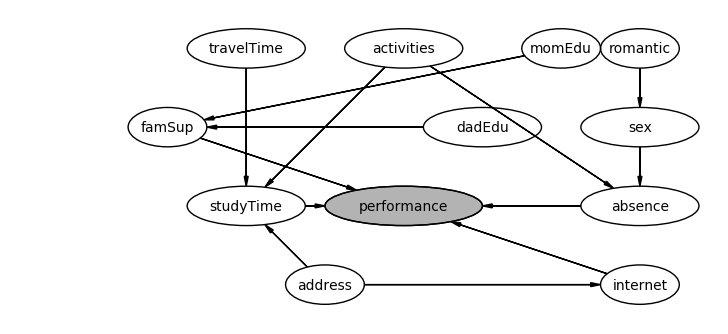

In [124]:
pgm = daft.PGM([9, 4], origin=[1, 0.5])
pgm.add_node(daft.Node('r', 'romantic', 9, 4, aspect=2))
pgm.add_node(daft.Node('s', 'sex', 9, 3, aspect=3))
pgm.add_node(daft.Node('a', 'address', 5, 1, aspect=2))
pgm.add_node(daft.Node('ab', 'absence', 9, 2, aspect=3))
pgm.add_node(daft.Node('t', 'travelTime', 4, 4, aspect=3))
pgm.add_node(daft.Node('ac', 'activities', 6, 4, aspect=3))
pgm.add_node(daft.Node('m', 'momEdu', 8, 4, aspect=2))
pgm.add_node(daft.Node('d', 'dadEdu', 7, 3, aspect=3))
pgm.add_node(daft.Node('i', 'internet', 9, 1, aspect=2))
pgm.add_node(daft.Node('st', 'studyTime', 4, 2, aspect=3))
pgm.add_node(daft.Node('f', 'famSup', 3, 3, aspect=2))
pgm.add_node(daft.Node('p', 'performance', 6, 2, aspect=4, observed=True))

pgm.add_edge('i', 'p')
pgm.add_edge('r', 's')
pgm.add_edge('a', 'i')
pgm.add_edge('s', 'ab')
pgm.add_edge('ab', 'p')
pgm.add_edge('a', 'st')

pgm.add_edge('st', 'p')
pgm.add_edge('t', 'st')


pgm.add_edge('ac', 'st')
pgm.add_edge('ac', 'ab')

pgm.add_edge('m', 'f')
pgm.add_edge('f', 'p')
pgm.add_edge('d', 'f')
pgm.render()

In [162]:
observed_values = [1.]

address = pymc.Bernoulli('address', .78, value=np.ones(len(observed_values)))

travelTime = pymc.Bernoulli('travelTime', .72, value=np.ones(len(observed_values)))
romantic = pymc.Bernoulli('romantic', .32, value=np.ones(len(observed_values)))
activities = pymc.Bernoulli('activities', .51, value=np.ones(len(observed_values)))
p_sex = pymc.Lambda('p_sex', lambda romantic=romantic: np.where(romantic, .42, .48))
sex = pymc.Bernoulli('sex', p_sex, value=np.ones(len(observed_values)))

momEdu = pymc.Bernoulli('momEdu', .34, value=np.ones(len(observed_values)))
dadEdu = pymc.Bernoulli('dadEdu', .25, value=np.ones(len(observed_values)))
p_famsup = pymc.Lambda('p_famsup', lambda momEdu = momEdu, dadEdu = dadEdu: np.where(momEdu, (np.where(dadEdu, .75, .62)) ,(np.where(dadEdu, .68, .58)) ))
famsup = pymc.Bernoulli('famsup', p_famsup, value=np.ones(len(observed_values)))

p_internet = pymc.Lambda('p_internet', lambda address=address: np.where(address, .90, .67))
internet = pymc.Bernoulli('internet', p_internet, value=np.ones(len(observed_values)))

p_studytime = pymc.Lambda('p_studytime', lambda address=address, travelTime=travelTime, activities=activities: np.where(address, np.where(travelTime,
                                                                                                                                              np.where(activities, 0.17, 0),
                                                                                                                                                    np.where(activities, .25, .22)),
                                                                                                                                                    np.where(travelTime,
                                                                                                                                                    np.where(activities, 0.2, .13),
                                                                                                                                                    np.where(activities, 0.34, .29))))
studytime = pymc.Bernoulli('studytime', p_studytime, value=np.ones(len(observed_values)))

p_absence = pymc.Lambda('p_absence', lambda activities = activities, sex = sex: np.where(activities, (np.where(sex, .77, .72)) ,(np.where(sex, .54, .66)) ))
absence = pymc.Bernoulli('absence', p_absence, value=np.ones(len(observed_values)))

p_performance = pymc.Lambda('p_performance', lambda internet=internet, studytime=studytime, absence=absence, famsup=famsup: np.where(internet, np.where(studytime,
                                                                                                                                              np.where(absence, np.where(famsup, .67, .67), np.where(famsup, .58 , .71)),
                                                                                                                                              np.where(absence, np.where(famsup, .47 , .54), np.where(famsup, .30 , .42))), 
                                                                                                                                              np.where(studytime,
                                                                                                                                              np.where(absence, np.where(famsup, 1.0 , .25), np.where(famsup, 0.0 , 0.0)),
                                                                                                                                              np.where(absence, np.where(famsup, .32 , .38), np.where(famsup, .25 , .17)))))





performance = pymc.Bernoulli('performance', p_performance, value=np.ones(len(observed_values)))

model = pymc.Model([performance, p_performance, absence, p_absence, studytime, p_studytime, internet, p_internet, famsup, p_famsup, dadEdu, momEdu, sex, p_sex, activities, romantic, travelTime, address ])


In [163]:
mcmc = pymc.MCMC(model)
mcmc.sample(10000, 2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 3.5 sec

In [167]:
trace_address = mcmc.trace('address')[:]
trace_travelTime = mcmc.trace('travelTime')[:]
trace_romantic = mcmc.trace('romantic')[:]
trace_activities = mcmc.trace('activities')[:]

trace_p_sex = mcmc.trace('p_sex')[:]
trace_sex = mcmc.trace('sex')[:]
trace_momEdu = mcmc.trace('momEdu')[:]
trace_dadEdu = mcmc.trace('dadEdu')[:]

trace_p_famsup = mcmc.trace('p_famsup')[:]
trace_famsup = mcmc.trace('famsup')[:]
trace_p_internet = mcmc.trace('p_internet')[:]
trace_internet = mcmc.trace('internet')[:]

trace_p_studytime = mcmc.trace('p_studytime')[:]
trace_studytime = mcmc.trace('studytime')[:]
trace_p_absence = mcmc.trace('p_absence')[:]
trace_absence = mcmc.trace('absence')[:]
trace_p_performance = mcmc.trace('p_performance')[:]
trace_performance = mcmc.trace('performance')[:]

Plotting p_internet_0
Plotting p_performance_0
Plotting p_sex_0
Plotting p_absence_0
Plotting dadEdu_0
Plotting absence_0
Plotting famsup_0
Plotting p_famsup_0
Plotting internet_0
Plotting studytime_0
Plotting romantic_0
Plotting p_studytime_0
Plotting sex_0
Plotting activities_0
Plotting address_0
Plotting momEdu_0
Plotting performance_0
Plotting travelTime_0


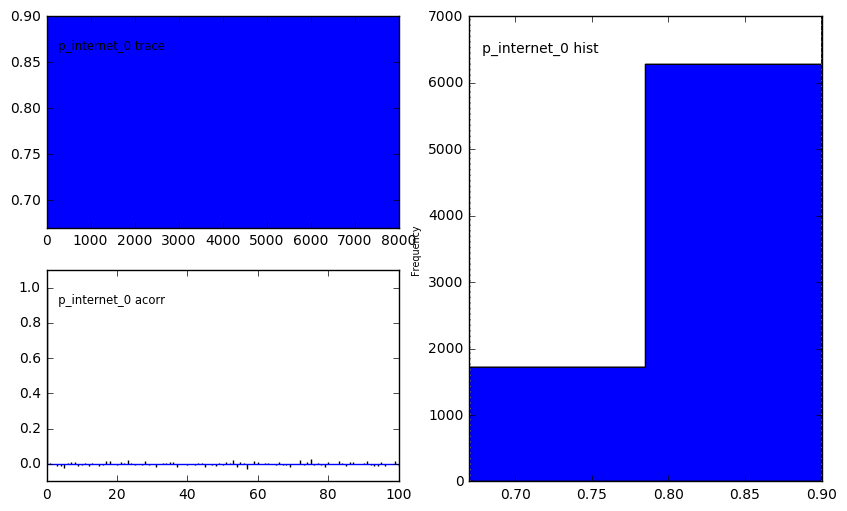

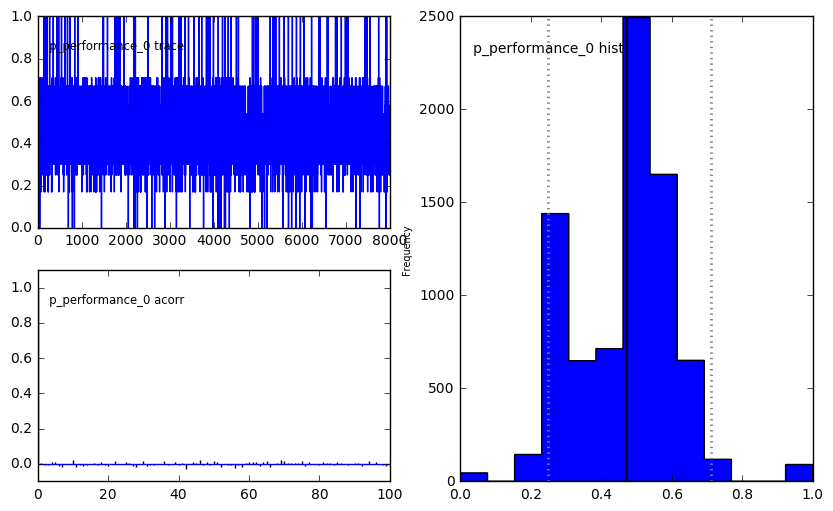

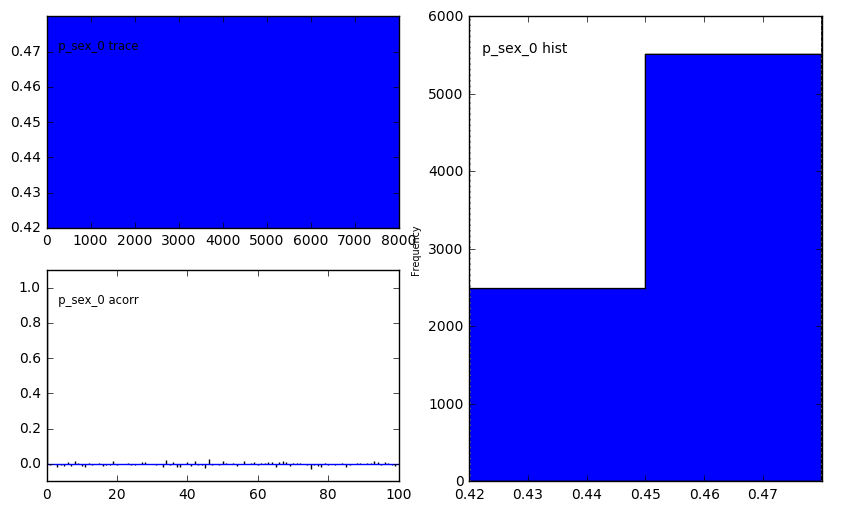

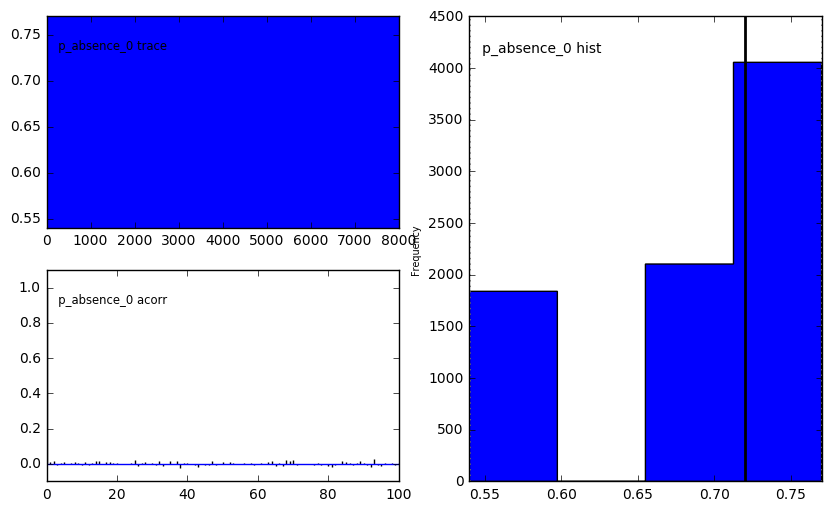

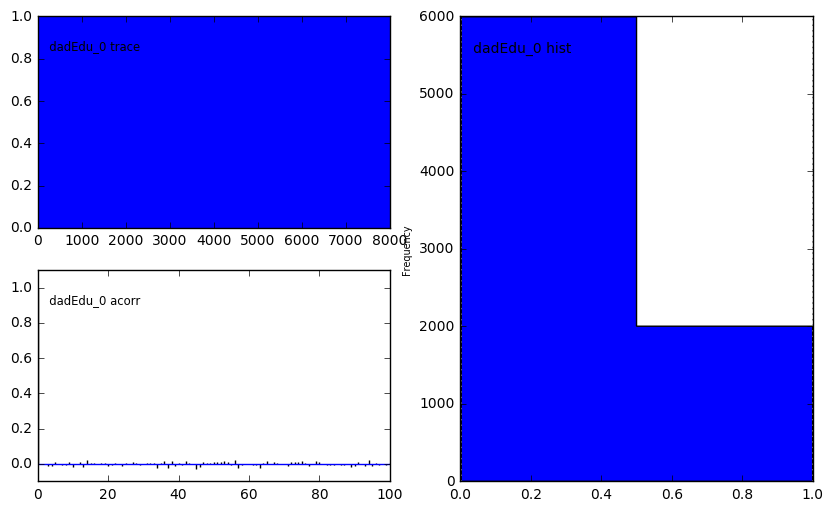

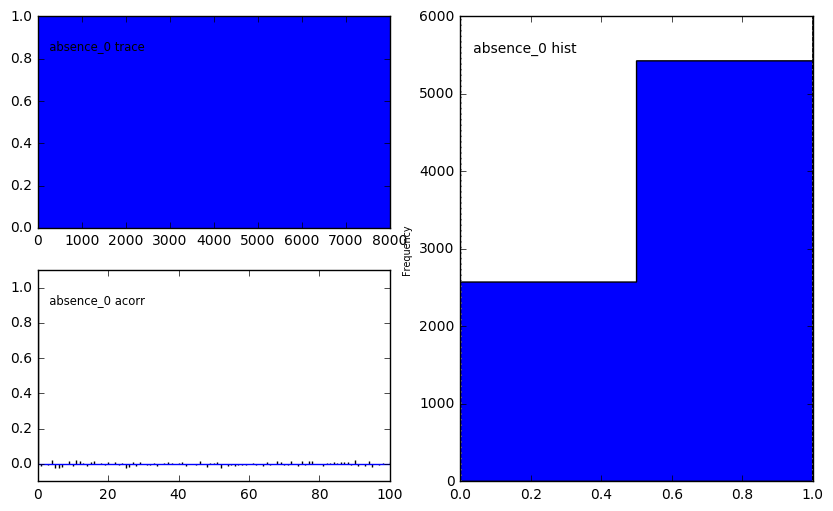

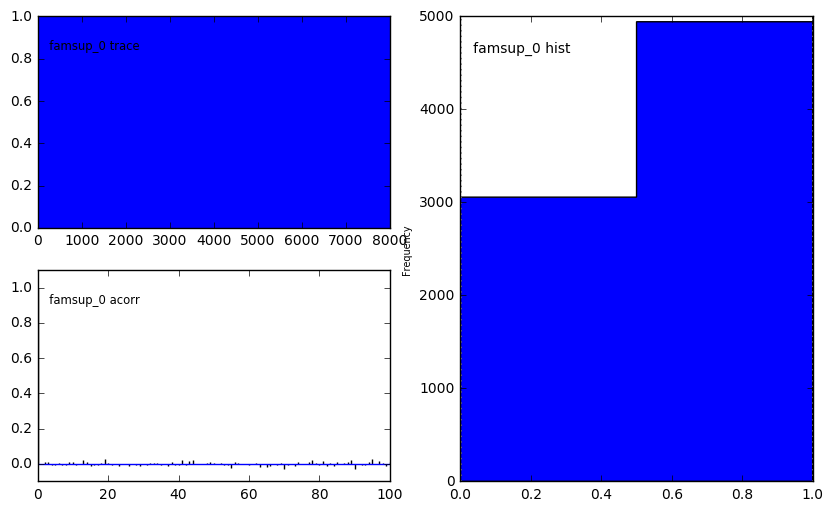

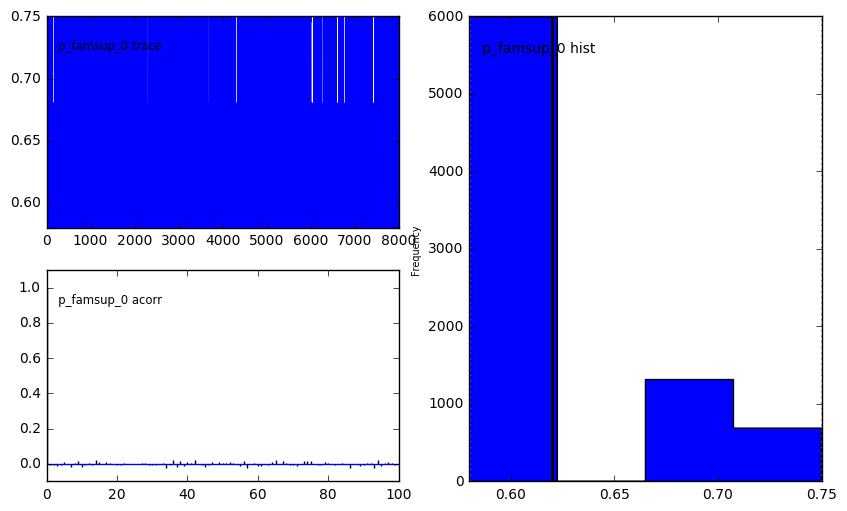

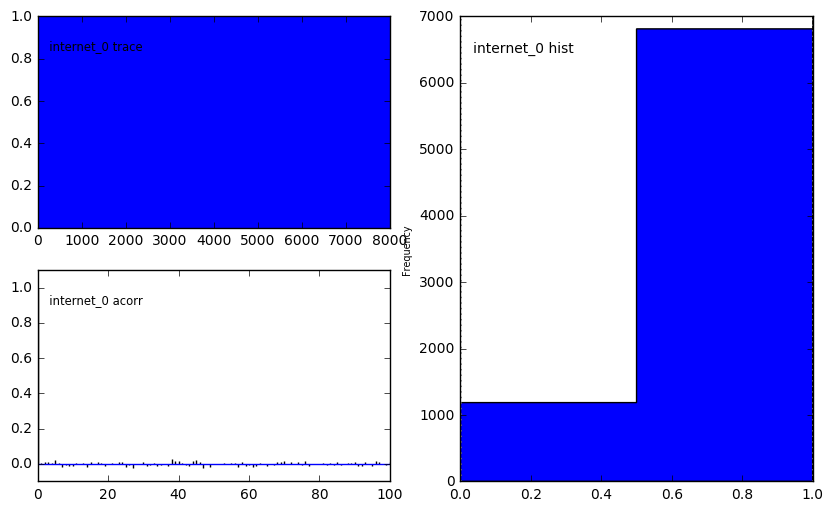

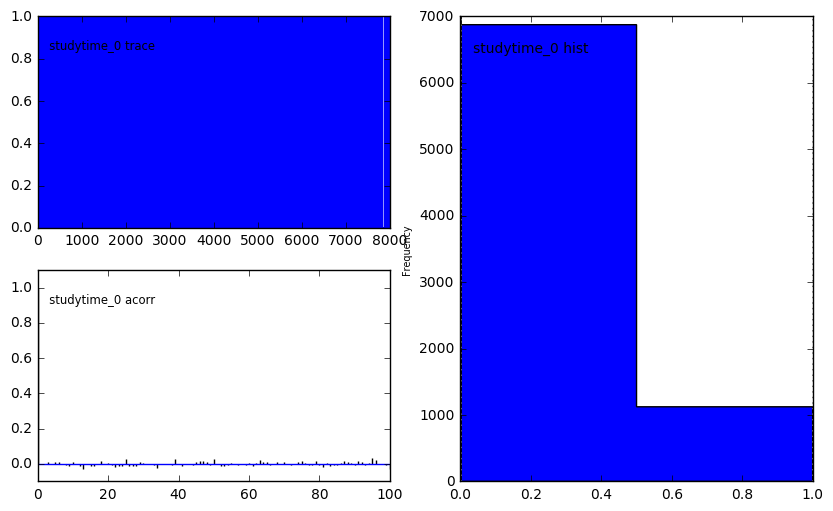

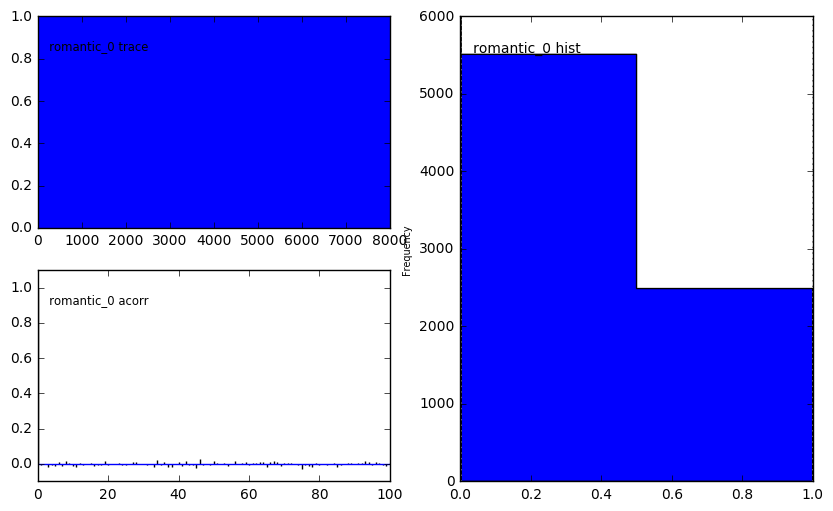

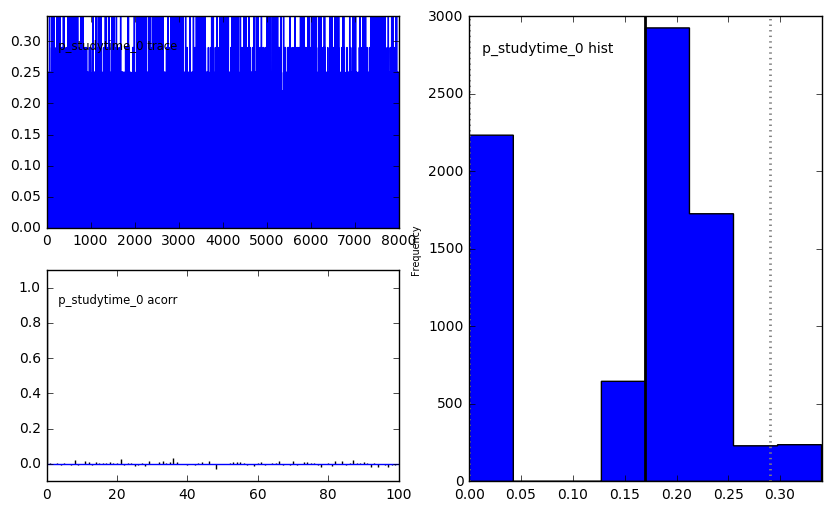

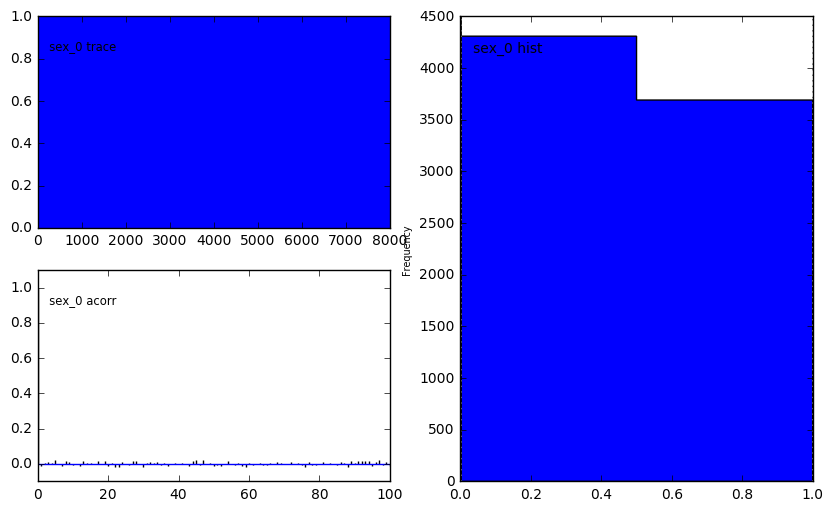

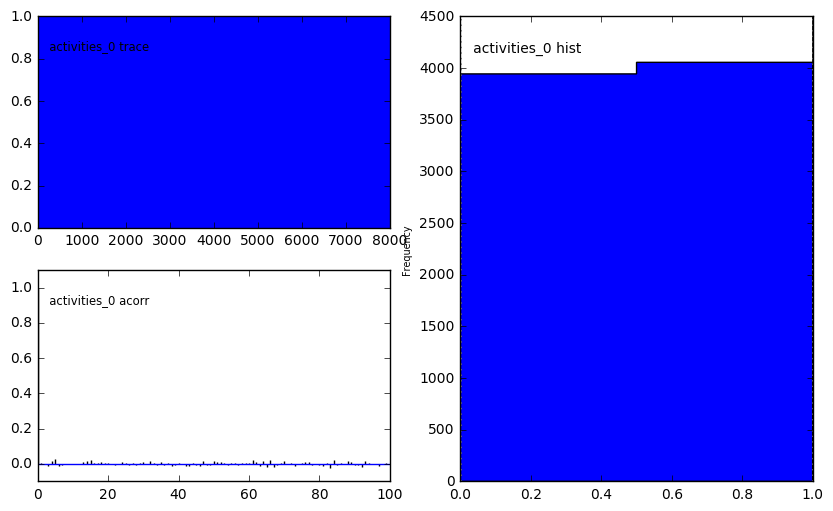

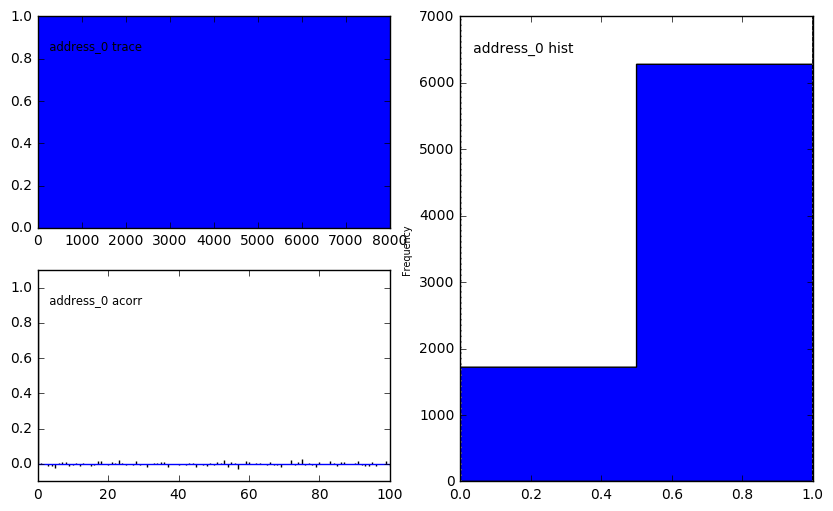

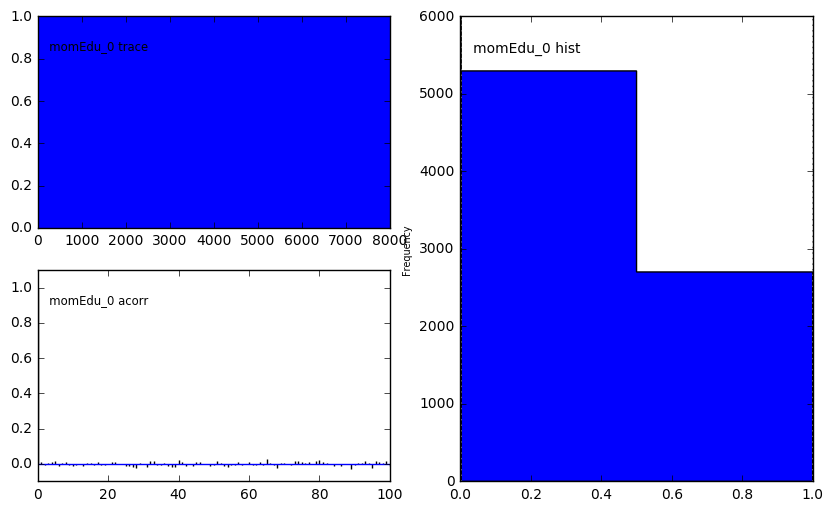

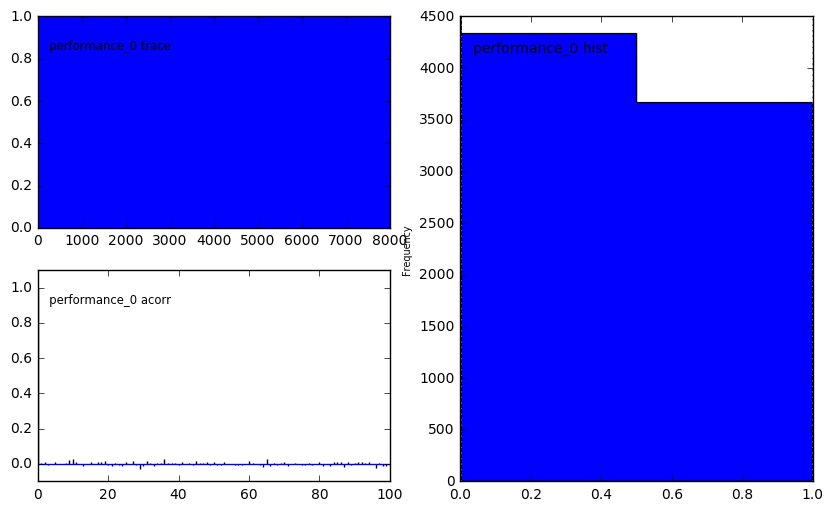

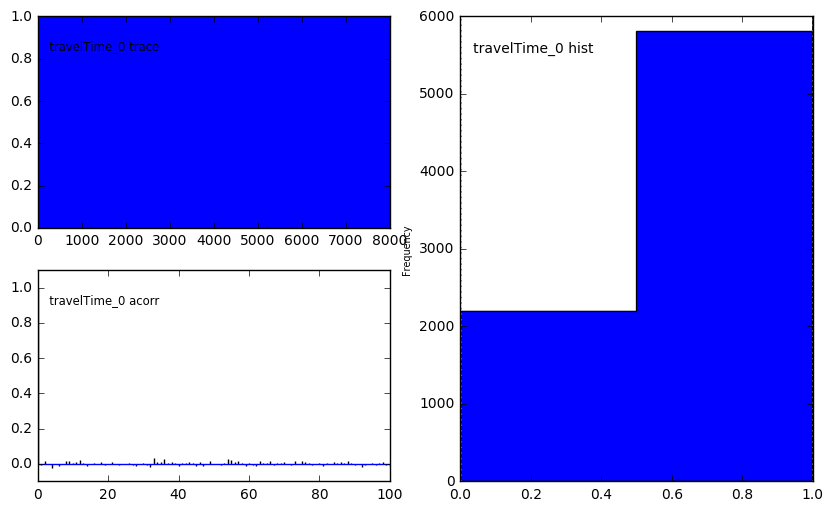

In [168]:
pymc.Matplot.plot(mcmc)

In [170]:
dictionary = {
              'Internet': [1 if ii[0] else 0 for ii in trace_internet.tolist() ],
              'Absence': [1 if ii[0] else 0 for ii in trace_absence.tolist() ],
              'Familly support': [ii[0] for ii in trace_famsup.tolist()],
              'Study time': [ii[0] for ii in trace_studytime.tolist()],
              'Performance': [ii[0] for ii in trace_p_performance.tolist()],
              }
df = pd.DataFrame(dictionary)
df.head()

,Absence,Familly support,Internet,Performance,Study time
0,1,True,1,0.47,False
1,1,True,1,0.47,False
2,1,False,1,0.67,True
3,1,False,1,0.54,False
4,1,False,1,0.54,False


In [178]:
#Given the student has a good performance (> 0.7), what is the probability that you were absent?
p_perf_absent = float(df[(df['Absence'] == 1) & (df['Performance'] > 0.7)].shape[0]) / df[df['Performance'] > 0.7].shape[0] 
print(p_perf_absent)

0.43333333333333335
